In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from re import search
from pathlib import Path
from simcore_tools import SpecReader, FileRenamer, get_params_specs

In [3]:
#yaml_files = list(Path('data/ocorr_results/').glob('*.yaml'))

In [4]:
# substring_to_replace = "v[0-9]+"
# replacement = "lp{:03d}_dr{:02d}"
# formatter_contents = ['filament:perlen_ratio', 'filament:driving_factor']
# renamer = FileRenamer(substring_to_replace, replacement, formatter_contents)

In [5]:
# for file in yaml_files:
#     renamer.rename(file, confirm=False)

In [6]:
# files = list(Path('data/ocorr_results').glob('*.spec'))

In [7]:
# for file in files:
#     sreader = SpecReader(file)
#     sreader.make_human_readable()

In [140]:
files = list(Path('data/ocorr_results').glob('*.spec.hr'))

In [143]:
files

[PosixPath('data/ocorr_results/ocorr_lp030_dr30_filament_mt.spec.hr'),
 PosixPath('data/ocorr_results/ocorr_lp020_dr03_filament_mt.spec.hr'),
 PosixPath('data/ocorr_results/ocorr_lp050_dr03_filament_mt.spec.hr'),
 PosixPath('data/ocorr_results/ocorr_lp015_dr30_filament_mt.spec.hr'),
 PosixPath('data/ocorr_results/ocorr_lp005_dr03_filament_mt.spec.hr'),
 PosixPath('data/ocorr_results/ocorr_lp040_dr30_filament_mt.spec.hr'),
 PosixPath('data/ocorr_results/ocorr_lp010_dr30_filament_mt.spec.hr'),
 PosixPath('data/ocorr_results/ocorr_lp020_dr10_filament_mt.spec.hr'),
 PosixPath('data/ocorr_results/ocorr_lp050_dr10_filament_mt.spec.hr'),
 PosixPath('data/ocorr_results/ocorr_lp005_dr10_filament_mt.spec.hr'),
 PosixPath('data/ocorr_results/ocorr_lp015_dr10_filament_mt.spec.hr'),
 PosixPath('data/ocorr_results/ocorr_lp040_dr10_filament_mt.spec.hr'),
 PosixPath('data/ocorr_results/ocorr_lp030_dr10_filament_mt.spec.hr'),
 PosixPath('data/ocorr_results/ocorr_lp010_dr03_filament_mt.spec.hr'),
 Posix

In [149]:
dr = search('dr[0-9]+', files[0].name)[0]
lp = search('lp[0-9]+', files[0].name)[0]
label = dr + '_' + lp

In [9]:
params, specs = get_params_specs(files[0])

In [13]:
stacked = specs.stack([0, 2])

In [118]:
avg_u = stacked.diff(axis=1).dropna(axis=1).sum(axis=1).unstack()
lengths = np.sqrt((avg_u**2).sum(axis=1))
avg_u.x /= lengths
avg_u.y /= lengths
avg_u = avg_u[['x', 'y']].stack().unstack([1, 2])

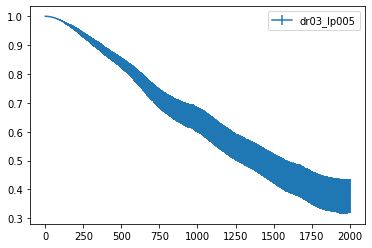

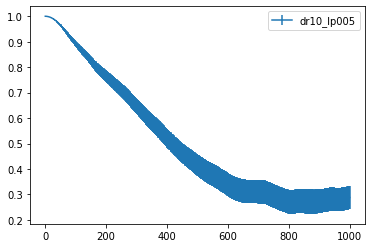

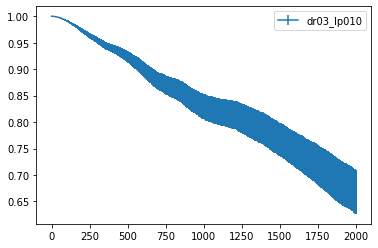

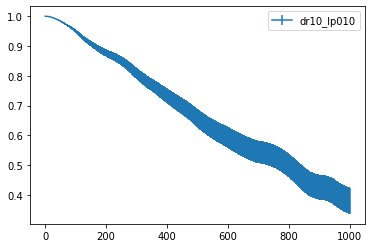

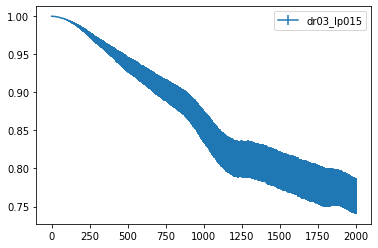

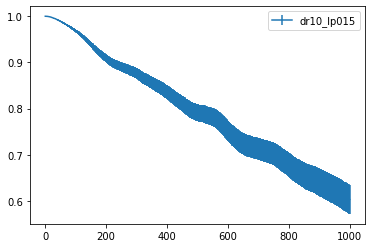

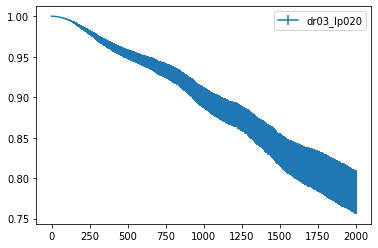

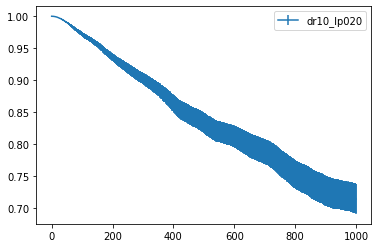

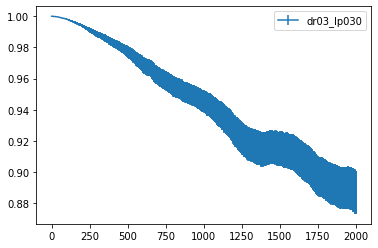

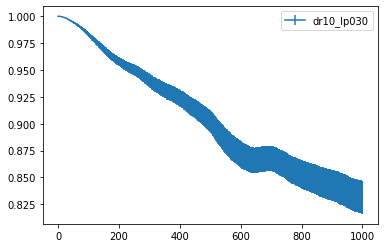

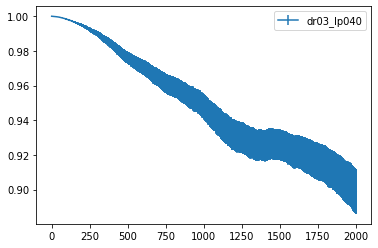

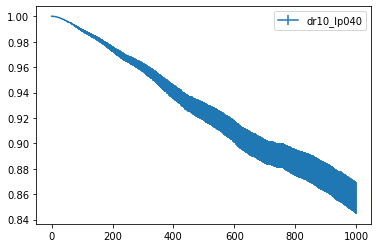

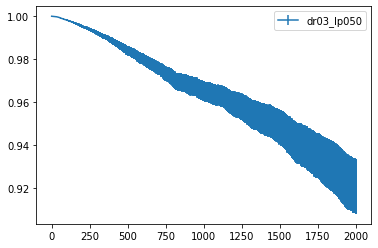

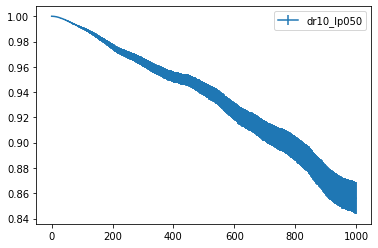

In [170]:
for file in files:
    params, specs = get_params_specs(file)
    dr = search('dr[0-9]+', file.name)[0]
    lp = search('lp[0-9]+', file.name)[0]
    label = dr + '_' + lp
    stacked = specs.stack([0, 2])
    avg_u = stacked.diff(axis=1).dropna(axis=1).sum(axis=1).unstack()
    lengths = np.sqrt((avg_u**2).sum(axis=1))
    avg_u.x /= lengths
    avg_u.y /= lengths
    avg_u = avg_u[['x', 'y']].stack().unstack([1, 2])
    if dr == 'dr30':
        continue
        #N = 500
    elif dr == 'dr10':
        N = 1500
    elif dr == 'dr03':
        N = 5000
    Nf = avg_u.columns.unique(level='filament').shape[0]
    Nit = avg_u.shape[0]//N
    results = np.zeros(N)
    results_err = np.zeros(N)
    for j in range(0, avg_u.shape[0], N):
        dot_prod = (avg_u.iloc[j] * avg_u.iloc[j:j+N]).values
        dot_prod = dot_prod[:, 0::2] + dot_prod[:, 1::2]
        results += dot_prod.mean(axis=1)
        results_err += (dot_prod**2).mean(axis=1)
    results /= Nit
    results_err /= Nit
    results_err = np.sqrt(results_err - results**2)/np.sqrt(Nit*Nf)
    np.save('ocorr_results_' + label, results)
    np.save('ocorr_results_err_' + label, results_err)
    plt.figure()
    plt.errorbar(x=np.linspace(0, N, N), y=results, yerr=results_err, label=label)
    plt.legend()
    plt.show()

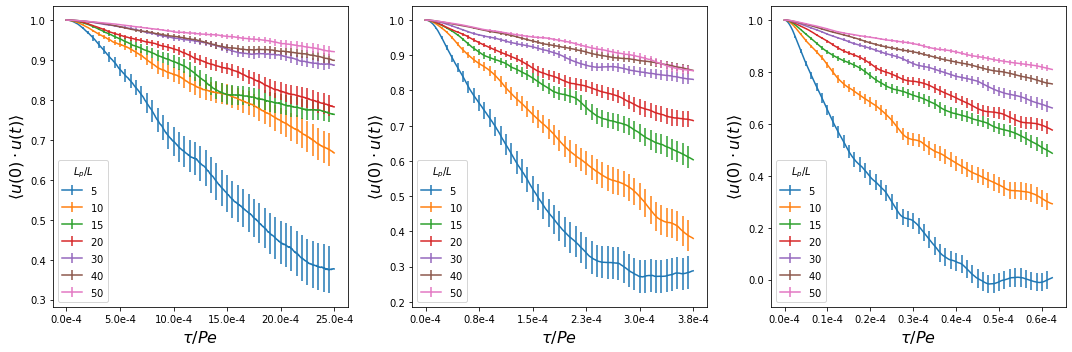

In [622]:


fig, ax = plt.subplots(1, 3, figsize=(15, 5))
#N=500
files = sorted(files)
for file in files:
    dr = search('dr[0-9]+', file.name)[0]
    lp = search('lp[0-9]+', file.name)[0]
    label = dr + '_' + lp
    if dr == 'dr30':
        axi = 2
        N=500
        errev = 10
        pe = 10**5
    elif dr == 'dr10':
        axi = 1
        N=1000
        errev = 20
        pe = 3.3333*10**4
    elif dr == 'dr03':
        axi = 0
        N=2000
        errev = 40
        pe = 10**4
    else:
        print(dr)
        continue
#    def xticklabel(a, b):
#        return params.delta[0] * params.n_spec[0] * 0.5 * a
#        return '{:2.1f}'.format(params.delta[0] * params.n_spec[0] * 0.5 * a/pe*10**4) + 'e-4'
    results = np.load('ocorr_results_' + label + '.npy')
    results_err = np.load('ocorr_results_err_' + label + '.npy')
    pltlabel = '${}$'.format(int(lp[2:]))
    ax[axi].errorbar(x=np.linspace(0, N, N), y=results, yerr=results_err, label=pltlabel, errorevery=errev)
    ax[axi].legend(title='$L_p/L$', loc='lower left', fontsize='medium')
    ax[axi].set_ylabel(r'$\langle u(0)\cdot u(t) \rangle$', fontsize=16)
    ax[axi].xaxis.set_major_locator(plt.MaxNLocator(7))
    ax[axi].set_xlabel(r'$\tau / Pe$ ', fontsize=16)
pe_numbers = [3*10**4, 3.3333*10**4, 10**5]
ax[0].xaxis.set_major_formatter(plt.FuncFormatter(
    lambda a, b : '{:2.1f}'.format(params.delta[0] * params.n_spec[0] * 0.5 * a) + 'e-4'))
ax[1].xaxis.set_major_formatter(plt.FuncFormatter(
    lambda a, b : '{:2.1f}'.format(params.delta[0] * params.n_spec[0] * 0.5 * a/3.33333) + 'e-4'))
ax[2].xaxis.set_major_formatter(plt.FuncFormatter(
    lambda a, b : '{:2.1f}'.format(params.delta[0] * params.n_spec[0] * 0.5 * a/10) + 'e-4'))
plt.tight_layout()
fig.savefig('ocorr.png', dpi=600)
plt.show()

In [163]:
params.delta[0] * params.n_spec[0] * 0.5

0.0125

In [ ]:
plt.legend()

In [177]:
params

,n_steps,n_spec,delta,n_filaments,diameter,length,bond_length,persistence_length,n_sites
0,20000000,1000,0.000025,10,1.0,60.0,2.307692,3000.0,27


In [176]:
specs

filament       fil000                                                   \
site          site000                        site001                     
coord               x            y    z            x            y    z   
time                                                                     
0          -51.446152     3.493061  0.0   -52.580703     1.483525  0.0   
1          -52.814097     1.611664  0.0   -53.806109    -0.471556  0.0   
2          -53.830189    -0.374695  0.0   -54.829495    -2.454021  0.0   
3          -54.740889    -2.471973  0.0   -55.814208    -4.513687  0.0   
4          -55.955373    -4.271206  0.0   -56.891596    -6.380299  0.0   
...               ...          ...  ...          ...          ...  ...   
19995    -9507.041535 -3923.541445  0.0 -9509.278079 -3924.106274  0.0   
19996    -9509.227718 -3924.105414  0.0 -9511.441337 -3924.757119  0.0   
19997    -9511.501057 -3924.732434  0.0 -9513.725881 -3925.343498  0.0   
19998    -9513.726343 -3925.268017  0.0 -9515.900754 -3926.038536  0.0   
19999    -9515.820168 -3926.061703  0.0 -9518.051450 -3926.646175  0.0   

filament                                              ...  fil009  \
site          site002                        site003  ... site023   
coord               x            y    z            x  ...       z   
time                                                  ...           
0          -53.590480    -0.591516  0.0   -54.637027  ...     0.0   
1          -54.806317    -2.550589  0.0   -55.797253  ...     0.0   
2          -55.806614    -4.543260  0.0   -56.799756  ...     0.0   
3          -56.901288    -6.547201  0.0   -57.933308  ...     0.0   
4          -57.849024    -8.479725  0.0   -58.809689  ...     0.0   
...               ...          ...  ...          ...  ...     ...   
19995    -9511.499510 -3924.725086  0.0 -9513.700334  ...     0.0   
19996    -9513.641637 -3925.452103  0.0 -9515.854751  ...     0.0   
19997    -9515.940105 -3925.990563  0.0 -9518.132465  ...     0.0   
19998    -9518.103579 -3926.721444  0.0 -9520.308070  ...     0.0   
19999    -9520.266108 -3927.287350  0.0 -9522.455596  ...     0.0   

filament                                                                  \
site          site024                         site025                      
coord               x             y    z            x             y    z   
time                                                                       
0           48.134665     64.963683  0.0    45.839867     65.207294  0.0   
1           45.849683     65.413293  0.0    43.551361     65.614402  0.0   
2           43.539750     65.416098  0.0    41.238326     65.570572  0.0   
3           41.188496     65.600412  0.0    38.889892     65.784691  0.0   
4           38.888240     65.826521  0.0    36.582930     65.923554  0.0   
...               ...           ...  ...          ...           ...  ...   
19995     2907.323623  15945.792889  0.0  2905.209574  15946.716794  0.0   
19996     2905.198775  15946.738216  0.0  2903.084181  15947.659451  0.0   
19997     2903.167525  15947.867485  0.0  2901.049923  15948.780372  0.0   
19998     2901.169300  15949.001884  0.0  2899.024248  15949.852188  0.0   
19999     2899.019177  15949.822933  0.0  2896.863344  15950.643945  0.0   

filament                                  
site          site026                     
coord               x             y    z  
time                                      
0           43.552120     65.510038  0.0  
1           41.246089     65.713731  0.0  
2           38.934273     65.689520  0.0  
3           36.594562     66.014649  0.0  
4           34.275675     65.958272  0.0  
...               ...           ...  ...  
19995     2903.085322  15947.617742  0.0  
19996     2900.968716  15948.580111  0.0  
19997     2898.926817  15949.682502  0.0  
19998     2896.827669  15950.559213  0.0  
19999     2894.710883  15951.474837  0.0  

[20000 rows x 810 columns]

In [178]:
from yaml import safe_load

In [554]:
yamls = sorted(list(Path('data/ocorr_results/').glob('*.yaml')))
files = sorted(list(Path('data/ocorr_results/').glob('*.spec.hr')))

In [579]:
thinning = 10
for y, f in zip(yamls, files):
    with open(y) as yf:
        p = safe_load(yf)
    Lsys = p['system_radius']
    L = p['filament'][0]['length']
    params, specs = get_params_specs()
    # Average filament positions
    avg_fil_pos = specs.iloc[::thinning].stack([1]).unstack([0]).mean(axis=0).unstack().transpose().stack([0])
    centers = (np.random.random((10, 2))-0.5)*Lsys
    CNNe = []
    avg_fil_pos.unstack()
    for center in centers:
        print("For center [{}, {}]:".format(center[0], center[1]))
        L = p['filament'][0]['length']
        Lsys = p['system_radius']
        
        # Shift to center, then wrap periodic boundary conditions
        avg_fil_pos['x'] += center[0]
        avg_fil_pos['y'] += center[1]
        wrapped_pos = avg_fil_pos.apply(pbc_wrap, args=([Lsys]))
        
        box_sizes = np.arange(L/2, Lsys, 10)
        NNe = []
        for size in box_sizes:
            print("For size {}:".format(size))

            tgby = wrapped_pos.groupby('time').apply(inside_box, box_center=np.array([0, 0]), box_size=size)
            NNe.append([size, tgby.mean(), tgby.std()])
            
        # Append results
        CNNe.append(NNe)
        
        # Shift back to original positions
        avg_fil_pos['x'] -= center[0]
        avg_fil_pos['y'] -= center[1]
    np.array(CNNe)

For center [2.128518919554445, 18.962551483796485]:
For size 30.0:
For size 40.0:
For size 50.0:
For size 60.0:
For size 70.0:
For size 80.0:
For size 90.0:
For center [12.405319718435791, -39.1180875872767]:
For size 30.0:
For size 40.0:
For size 50.0:
For size 60.0:
For size 70.0:
For size 80.0:
For size 90.0:
For center [3.306523081454127, 25.17272312871316]:
For size 30.0:
For size 40.0:
For size 50.0:
For size 60.0:
For size 70.0:
For size 80.0:
For size 90.0:
For center [30.87946679076613, -29.045190991834858]:
For size 30.0:
For size 40.0:
For size 50.0:
For size 60.0:
For size 70.0:
For size 80.0:
For size 90.0:
For center [-41.44690463798694, 31.235243123987956]:
For size 30.0:
For size 40.0:
For size 50.0:
For size 60.0:
For size 70.0:
For size 80.0:
For size 90.0:
For center [13.080127691804533, 3.961239527160887]:
For size 30.0:
For size 40.0:
For size 50.0:
For size 60.0:
For size 70.0:
For size 80.0:
For size 90.0:
For center [14.07650700866635, -38.43000559042108]:
For s

For size 40.0:
For size 50.0:
For size 60.0:
For size 70.0:
For size 80.0:
For size 90.0:
For center [36.990290989250404, 37.38005851112987]:
For size 30.0:
For size 40.0:
For size 50.0:
For size 60.0:
For size 70.0:
For size 80.0:
For size 90.0:
For center [-10.462528349904376, -27.743898340108142]:
For size 30.0:
For size 40.0:
For size 50.0:
For size 60.0:
For size 70.0:
For size 80.0:
For size 90.0:
For center [9.932053526845674, 43.44665878791773]:
For size 30.0:
For size 40.0:
For size 50.0:
For size 60.0:
For size 70.0:
For size 80.0:
For size 90.0:
For center [-37.88010736057837, -1.8314741928445954]:
For size 30.0:
For size 40.0:
For size 50.0:
For size 60.0:
For size 70.0:
For size 80.0:
For size 90.0:
For center [-5.788052100720609, -24.06019372573127]:
For size 30.0:
For size 40.0:
For size 50.0:
For size 60.0:
For size 70.0:
For size 80.0:
For size 90.0:
For center [4.472652828219415, 23.14225211414842]:
For size 30.0:
For size 40.0:
For size 50.0:
For size 60.0:
For size 

KeyboardInterrupt: 

In [581]:
centers = (np.random.random((10, 2))-0.5)*Lsys


In [583]:
for center in centers:
    print("For center [{}, {}]:".format(center[0], center[1]))


For center [-4.137515344383247, 15.292056837987289]:
For center [12.262826677103966, 45.613686113493166]:
For center [17.798821595043336, 17.68148022094511]:
For center [27.40144595772801, -1.9560486988547288]:
For center [-4.7811614841891785, 27.823053281274625]:
For center [-21.020758789192318, -14.108654349388983]:
For center [27.992900135572572, 10.91212781707812]:
For center [41.94823020794847, 12.715833226256102]:
For center [31.61781549260163, 25.236643832184146]:
For center [4.263255905581243, -47.45205556450247]:


In [573]:
avg_fil_pos = specs.stack([1]).unstack([0]).mean(axis=0).transpose()


In [588]:
files[0].name.partition('.')[0] + '_gnf'

'ocorr_lp005_dr03_filament_mt_gnf'

In [576]:
avg_fil_pos.unstack()

time                0          1          2          3          4      \
filament coord                                                          
fil000   x     -64.004617 -64.951223 -65.831309 -66.741834 -67.567055   
         y     -23.690155 -25.785472 -27.838536 -29.912549 -31.913162   
         z       0.000000   0.000000   0.000000   0.000000   0.000000   
fil001   x     -84.283096 -82.711663 -81.141915 -79.632972 -78.081799   
         y      58.896650  57.253156  55.540458  53.831561  52.151040   
         z       0.000000   0.000000   0.000000   0.000000   0.000000   
fil002   x     -81.002525 -79.380957 -77.675127 -75.910974 -74.195560   
         y     -17.092592 -18.688342 -20.318940 -21.943696 -23.510445   
         z       0.000000   0.000000   0.000000   0.000000   0.000000   
fil003   x      -7.376533  -6.418361  -5.395702  -4.365245  -3.480695   
         y     -86.981427 -88.947312 -90.999460 -93.076521 -95.060906   
         z       0.000000   0.000000   0.000000   0.000000   0.000000   
fil004   x     -89.301183 -87.150464 -84.985117 -82.733045 -80.560554   
         y      29.821800  29.157120  28.515245  27.830710  27.162080   
         z       0.000000   0.000000   0.000000   0.000000   0.000000   
fil005   x      83.864331  85.924903  87.820853  89.818868  91.748920   
         y      58.929358  57.753352  56.614117  55.445826  54.407959   
         z       0.000000   0.000000   0.000000   0.000000   0.000000   
fil006   x     -13.879721 -12.387532 -10.985181  -9.607568  -8.205075   
         y      55.261740  53.351263  51.500888  49.618648  47.793206   
         z       0.000000   0.000000   0.000000   0.000000   0.000000   
fil007   x      72.894109  73.682584  74.496119  75.210616  75.956110   
         y     -42.173744 -40.004885 -37.837802 -35.734820 -33.619762   
         z       0.000000   0.000000   0.000000   0.000000   0.000000   
fil008   x     -60.392413 -60.703486 -60.933293 -61.249721 -61.504788   
         y      27.408313  29.721202  32.015302  34.295141  36.585806   
         z       0.000000   0.000000   0.000000   0.000000   0.000000   
fil009   x      73.444287  71.139393  68.836381  66.478722  64.173721   
         y      63.695409  63.775461  63.850188  63.932984  63.955233   
         z       0.000000   0.000000   0.000000   0.000000   0.000000   

time                5          6           7           8           9      ...  \
filament coord                                                            ...   
fil000   x     -68.412158 -69.383272  -70.271488  -71.187843  -72.115161  ...   
         y     -34.022086 -36.153067  -38.268322  -40.434973  -42.550825  ...   
         z       0.000000   0.000000    0.000000    0.000000    0.000000  ...   
fil001   x     -76.570741 -75.052297  -73.559685  -72.109144  -70.704649  ...   
         y      50.392833  48.612984   46.849334   45.102286   43.298381  ...   
         z       0.000000   0.000000    0.000000    0.000000    0.000000  ...   
fil002   x     -72.603986 -70.900036  -69.089972  -67.344961  -65.576219  ...   
         y     -24.981105 -26.496818  -27.988884  -29.570649  -31.081809  ...   
         z       0.000000   0.000000    0.000000    0.000000    0.000000  ...   
fil003   x      -2.543866  -1.613189   -0.781524    0.071165    0.838382  ...   
         y     -97.122059 -99.269287 -101.374674 -103.566323 -105.722074  ...   
         z       0.000000   0.000000    0.000000    0.000000    0.000000  ...   
fil004   x     -78.350814 -76.117722  -73.866370  -71.704416  -69.485996  ...   
         y      26.551963  25.875342   25.245254   24.608216   23.941015  ...   
         z       0.000000   0.000000    0.000000    0.000000    0.000000  ...   
fil005   x      93.789291  95.831183   97.799920   99.738399  101.778198  ...   
         y      53.274742  52.139334   51.055019   49.920323   48.752097  ...   
         z       0.000000   0.000000    0.000000    0.000000    0.000000  ...   
fil006   x      -6.762406  -5.399616   -4.0

In [193]:
with open(yamls[0]) as f:
    p = safe_load(f)

In [240]:
xperiodic = p['system_radius']

In [283]:
sstack = specs.stack([0, 1])

In [259]:
sstack['x'] = sstack['x'].apply(pbc_wrap, args=([xperiodic]))
sstack['y'] = sstack['y'].apply(pbc_wrap, args=([xperiodic]))

In [348]:
avg_fil_pos = specs.stack([1]).unstack([0]).mean(axis=0).unstack().transpose()

In [434]:
avg_fil_pos['r'] = list(zip(avg_fil_pos['x'], avg_fil_pos['y']))

In [467]:
avg_fil_pos['r'] = avg_fil_pos['r'].apply(np.array)

In [380]:
ravg = np.array([avg_fil_pos['x'].values, avg_fil_pos['y'].values]).transpose()

In [416]:
np.apply_along_axis(inside_box, 1, ravg, box_center=np.array([0, 0]), box_size=100).shape

(200000, 2)

In [456]:
np.array(((1, 2), (3, 4)))

array([[1, 2],
       [3, 4]])

In [527]:
def inside_box(x, box_center, box_size):
    return sum((x['x'] < (box_center[0] + box_size)) & 
              (x['x'] > (box_center[0] - box_size)) &
              (x['y'] < (box_center[1] + box_size)) & 
              (x['y'] > (box_center[1] - box_size)))

def pbc_wrap(x, xperiodic):
    x[x < 0] = (x / xperiodic - x // xperiodic - 1) * xperiodic
    x[x >= 0] = (x / xperiodic - x // xperiodic) * xperiodic
    return x
#     print(x)
#     print(x.shape)
#     return sum((x[:][0] < (box_center[0] + box_size)) & 
#                (x[:][0] > (box_center[0] - box_size)) & 
#                (x[:][1] > box_center[1] - box_size) & 
#                (x[:][1] < box_center[1] + box_size))

In [552]:
center = np.array([0, 0])
L = p['filament'][0]['length']
Lsys = p['system_radius']
box_sizes = np.arange(L/2, Lsys/2, 10)

NNe = []
for size in box_sizes:
    tgby = revery10.groupby('time').apply(inside_box, box_center=center, box_size=size)
    NNe.append([size, tgby.mean(), tgby.std()])

revery10['x'] += Lsys
revery10['y'] += Lsys


for size in box_sizes:
    tgby = revery10.groupby('time').apply(inside_box, box_center=center, box_size=size)
    NNe.append([size, tgby.mean(), tgby.std()])
#({'r': lambda x: list(inside_box(x, box_center=center, box_size=box_size))})
                                       
#ibx = tgby['x'].agg(inside_box, box_center=center[0], box_size=box_size)
#iby = tgby['y'].agg(inside_box, box_center=center[0], box_size=box_size)

                               #  'y': [inside_box, box_center=center[1], box_size=box_size]})

In [553]:
NNe

[[30.0, 0.8925, 0.9001938260520514],
 [40.0, 1.601, 1.1164328063549336],
 [50.0, 2.528, 1.3300753927034128],
 [60.0, 3.6315, 1.4845233763155816],
 [70.0, 4.911, 1.5678992805907652],
 [80.0, 6.4225, 1.5106736303413468],
 [90.0, 8.1, 1.2408746451364343]]

In [548]:
p['filament'][0]['length']

60

In [534]:
tgby.std()

0.30993644595308

In [345]:
box_center = (0.0, 0.0)
box_size = 7

4054

In [542]:
revery10 = avg_fil_pos.unstack()[::10].stack()

In [403]:
r = np.array([10, 9])
box_center = np.array([4, 4])
box_size = 6

In [436]:
np.array((2, 1))

array([2, 1])

In [406]:
((r < (box_center + box_size)) & (r > (box_center - box_size)))

array([False,  True])

In [312]:
pbc_wrap(vals, p['system_radius'])

KeyboardInterrupt: 

In [313]:
vals

array([[-51.446151920679185, 3.4930613173247487, 0.0,
        array([-51.44615192,   3.49306132])],
       [-52.580702858446465, 1.4835245655847733, 0.0,
        array([-52.58070286,   1.48352457])],
       [-53.59047990104436, -0.5915161837077516, 0.0,
        array([-53.5904799 ,  -0.59151618])],
       ...,
       [2899.0191771095056, 15949.822932823436, 0.0,
        array([ 2899.01917711, 15949.82293282])],
       [2896.863343798501, 15950.643945006936, 0.0,
        array([ 2896.8633438 , 15950.64394501])],
       [2894.7108832810018, 15951.474837045746, 0.0,
        array([ 2894.71088328, 15951.47483705])]], dtype=object)

In [ ]:
value = -192
periodic = 146.4
over = (value/periodic - value//periodic - 1)
over * periodic

In [303]:
191.2//periodic

1.0

In [237]:
pbc_wrap(value, periodic)

44.79999999999998

In [225]:
192.9 - 146.1

46.80000000000001

In [226]:
value/periodic

4.320328542094456

In [227]:
value//periodic

4.0

In [206]:
.323287671232877 * 631.2

204.05917808219198

In [ ]:
0.32

In [204]:
631.2/146

4.323287671232877